In [1]:
#EKF that estimates following state: x[q;v;a_d] for one chief and one deputy satellite
#Robotics Exploration Lab
#Fausto Vega and Paulo Fisch

#State Estimator assuming GPS measurements
using LinearAlgebra
using ForwardDiff
using SatelliteDynamics
using BenchmarkTools

In [2]:
#Some constants
RE = 6378.0 #Radius of the Earth (km)
μ = 398600.0 #Standard gravitational parameter of Earth

398600.0

In [3]:
function ground_truth_sat_dynamics(x, epc)
    
    r = x[1:3] #satellite position in inertial frame
    v = x[4:6] #satellite velocity in inertial frame
        
    #look up this term. seems to give a rotation matrix
    PN = bias_precession_nutation(epc)
    
    #Compute the sun and moon positions in ECI frame
    r_sun = sun_position(epc)
    r_moon = moon_position(epc)
    
    #define the acceleration variable
    a = zeros(eltype(x), 3)
    
    #compute acceleration caused by Earth gravity (includes J2)
    #modeled by a spherical harmonic gravity field
    #look up this term. seems to give a rotation matrix
#     PN = bias_precession_nutation(epc)
#     Earth_r    = earth_rotation(epc)
#     rpm  = polar_motion(epc) 

#     R = rpm*Earth_r*PN
#     n_grav = 10
#     m_grav = 10
#     #main contribution in acceleration (seemed to not be equal to the Series Expansion of gravity)
#     a+= accel_gravity(x, R, n_grav, m_grav)
    
    
    #this is the gravity code that is working
    ###########################################################################################################
    #compute the gravitational acceleration based off the series expansion up to J2
    μ = 3.986004418e14 #m3/s2
    J2 = 1.08264e-3 
        
    a_2bp = (-μ*r)/(norm(r))^3
    
    Iz = [0,0,1]
    
    a_J2 = ((3*μ*J2*R_EARTH^2)/(2*norm(r)^5))*((((5*dot(r, Iz)^2)/norm(r)^2)-1)*r - 2*dot(r,Iz)*Iz)     

    a_grav = a_2bp + a_J2
    
    a += a_grav
    ############################################################################################################
    
    #atmospheric drag
    #compute the atmospheric density from density harris priester model
    ρ = density_harris_priester(epc,r)
    #ρ = 1.15e-12 #fixed atmospheric density in kg/m3

    
    #computes acceleration due to drag in inertial directions
    cd = 2.0 #drag coefficient
    area_drag = 0.1 #in m2 #area normal to the velocity direction
    m = 1.0
    
    a += accel_drag(x, ρ, m, area_drag, cd, Array{Real,2}(PN))
    
    a_drag = accel_drag(x, ρ, m, area_drag, cd, Array{Real,2}(PN))
    
    #Solar Radiation Pressure
    area_srp = 1.0
    coef_srp = 1.8
    a += accel_srp(x, r_sun, m, area_srp, coef_srp)
    a_srp = accel_srp(x, r_sun, m, area_srp, coef_srp)
    
    #acceleration due to external bodies
    a+= accel_thirdbody_sun(x, r_sun)
    a_sun = accel_thirdbody_sun(x, r_sun)
    
    #COMMENTED FOR TESTING
    a+= accel_thirdbody_moon(x, r_moon)
    a_moon = accel_thirdbody_moon(x, r_moon)
    
    a_unmodeled = a_srp + a_sun + a_moon
            
    xdot = x[4:6]
    vdot = a
    
    x_dot = [xdot; vdot]
    
    return x_dot, a_unmodeled, ρ, a_drag
    
end

ground_truth_sat_dynamics (generic function with 1 method)

In [4]:
ρ_max = 5e-11 #in kg/m3
ρ_min = 2e-14 #in kg/m3

2.0e-14

In [5]:
function RK4(x, t, h)
    
    f1,_, _, _ = ground_truth_sat_dynamics(x, t) 
    f2,_, _, _ = ground_truth_sat_dynamics(x+0.5*h*f1, t+h/2)
    f3,_, _, _ = ground_truth_sat_dynamics(x+0.5*h*f2, t+h/2)
    f4,_, _, _ = ground_truth_sat_dynamics(x+h*f3, t+h)
    
    xnext = x+(h/6.0)*(f1+2*f2+2*f3+f4)
        
    return xnext
    
end

RK4 (generic function with 1 method)

In [6]:
# initial time for sim
epc0 = Epoch(2012, 11, 8, 12, 0, 0, 0.0)

Epoch(2012-11-08T11:59:25.000Z)

In [7]:
#Test of some of the SatelliteDynamics functions

#Orbit we want (around ISS orbit conditions)
iss1 = [6871e3, 0.00064, 51.6450, 1.0804, 27.7899, 190];

# Convert osculating elements to Cartesean state
# returns position and velocity (m, m/s). This is the intial position
eci0_1 = sOSCtoCART(iss1, use_degrees=true)

#find the period of the orbit (seconds). only dependent on semi major axis
T = orbit_period(iss1[1])

#final time of simulation
epcf = epc0 + T

Epoch(2012-11-08T13:33:53.144Z)

In [8]:
h = 1 #1 Hz the timestep

x_0 = eci0_1

#x_0d = zeros(size(x_0)[1])
#x_0d[1:3] = x_0[1:3]+1000*randn(3)
#x_0d[4:6] = x_0[4:6]+10*randn(3)
display(x_0)
#display(x_0d)

#number of orbits to simulate
orbit_num = 0.1

#final time for the simulation (period x number of orbits)
Tf = T*orbit_num

#run the rk4
t = Array(range(0,Tf, step=h)) #create a range to final time at constant time step
    
all_x_c = zeros(length(x_0), length(t)) #variable to store all x of chief
#all_x_d = zeros(length(x_0), length(t)) #variable to store all x of deputy
    
all_x_c[:,1] = x_0 #set the initial state of chief
#all_x_d[:,1] = x_0d #set the initial state of deputy

for k=1:(length(t) - 1)
            
    current_t = epc0+t[k] #calculate the current time
        
    all_x_c[:,k+1] = RK4(all_x_c[:,k], current_t, h) #calculate the next state for chief
    #all_x_d[:,k+1] = RK4(all_x_d[:,k], current_t, h) #calculate the next state for chief
        
end

#contains all the ground truth states
x_hist = all_x_c

6-element Vector{Float64}:
    -5.384009806494038e6
    -2.715541505256187e6
    -3.3027935472528217e6
  4733.13249886581
 -3644.4068768958364
 -4717.485677232028

6×567 Matrix{Float64}:
    -5.38401e6     -5.37927e6     -5.37453e6  …     -1.86157e6     -1.85424e6
    -2.71554e6     -2.71918e6     -2.72282e6        -4.12901e6     -4.13021e6
    -3.30279e6     -3.30751e6     -3.31222e6        -5.17049e6     -5.17216e6
  4733.13        4739.73        4746.32           7325.92        7328.2
 -3644.41       -3641.07       -3637.74          -1195.59       -1190.54
 -4717.49       -4713.42       -4709.35       …  -1677.19       -1670.84

In [9]:
using PGFPlotsX

x_hist_scaled = x_hist*1e-3 # get the measurement to km (if needed)

#plot(x_hist[1,:], x_hist[2,:], x_hist[3,:], title="Ground Truth", label="satellite trajectory")
t = Array(range(0,Tf, step=h)) 

all_a_unmodeled = zeros((3, length(t)))

all_drag = zeros((3, length(t)))

ρ_all = zeros(length(t))

for i in 1:length(t)
    
    current_time = epc0 + t[i]
    
    ẋ, a_unmodeled, ρ_t, a_drag = ground_truth_sat_dynamics(x_hist[:,i], current_time)
    
    ρ_all[i] = ρ_t
    
    all_a_unmodeled[:,i] = a_unmodeled
    
    all_drag[:,i] = a_drag

end

In [10]:
#Ground truth data that concatenates satellite pose with the truth drag force using SatelliteDynamics.jl
truth_data = [x_hist; all_drag]

9×567 Matrix{Float64}:
    -5.38401e6      -5.37927e6   …     -1.86157e6      -1.85424e6
    -2.71554e6      -2.71918e6         -4.12901e6      -4.13021e6
    -3.30279e6      -3.30751e6         -5.17049e6      -5.17216e6
  4733.13         4739.73            7325.92         7328.2
 -3644.41        -3641.07           -1195.59        -1190.54
 -4717.49        -4713.42        …  -1677.19        -1670.84
    -4.56735e-6     -4.57593e-6        -7.83767e-6     -7.83932e-6
     3.27523e-6      3.2738e-6          1.18302e-6      1.17785e-6
     4.75077e-6      4.74895e-6         1.87083e-6      1.86355e-6

In [11]:
#standard deviation associated to the measurement
std_gps_measurement = 1 #*1e-3 #in km. ~10 m

#assume that it is additive noise (measurement noise)
R = I(3)*((std_gps_measurement)^2)/3

R = convert(Matrix{Float64}, R)
sqrt(R)*randn(3)

3-element Vector{Float64}:
  0.10522851028942216
  0.30061925268909195
 -0.7295922442313431

In [12]:
#standard deviation associated to the measurement
std_cv_measurement = 360 #*1e-3 #in km. ~10 m

#assume that it is additive noise (measurement noise)
R_cv = I(6)*((std_cv_measurement)^2)/3

R_cv = convert(Matrix{Float64}, R_cv)
sqrt(R_cv)*randn(6)

6-element Vector{Float64}:
   -9.740141757940986
  137.27215627776502
  200.9667402611508
  169.27074769060877
 -239.8433674858915
  183.73845986713326

In [13]:
GPS_num = size(x_hist_scaled)[2]

GPS_measurements = zeros(3, GPS_num)

for i in 1:GPS_num
    
    GPS_measurements[:, i] = x_hist[1:3, i] + sqrt(R)*randn(3)
    
end

In [14]:
#Random positions for the features (trying to make this roughly corespond to points on the surface of the Earth in ECI
z1 = randn(3)
z1 = RE*z1/norm(z1)

z2 = z1+(100*randn(3))
z2 = RE*z2/norm(z2)

z_stack = [z1;z2]

6-element Vector{Float64}:
 -2722.4084348426463
 -4108.01495388647
  4048.652794763062
 -2765.394370407712
 -4028.5937096296607
  4099.013381150355

In [15]:
function cd_measurement_function(x)
    measurement = zeros(4)
    measurement[1:3] = x[1:3]
    measurement[4] = norm(x[1:3] - x[7:9])
    return measurement
end

cd_measurement_function (generic function with 1 method)

In [16]:
function cv_measurement_function(x,z)
    #x_pos = x[1:3]
    z1 = z[1:3]
    z2 = z[4:6]
    y1 = z1-x[1:3]
    y1 = y1/norm(y1)

    y2 = z2-x[1:3]
    y2 = y2/norm(y2)
    
    return [y1; y2]
end

cv_measurement_function (generic function with 1 method)

In [17]:
CV_num = size(x_hist_scaled)[2]

CV_measurements = zeros(6, CV_num)

for i in 1:CV_num
    
    CV_measurements[:, i] = cv_measurement_function(x_hist[1:3, i],z_stack) + sqrt(R_cv)*randn(6)
    
end

In [18]:
function cv_measurement_jacobian(x,z)
    C = ForwardDiff.jacobian(_x -> cv_measurement_function(_x,z),x)
    return C
end

cv_measurement_jacobian (generic function with 1 method)

In [19]:
x_test = x_hist[1:3,1]
y_test = cv_measurement_function(x_test,z_stack)

6-element Vector{Float64}:
 0.7829008041512816
 0.3944750211122317
 0.4810985227349808
 0.7828920553230553
 0.39448531859528485
 0.48110431626084876

In [20]:
cv_measurement_jacobian(x_test,z_stack)

6×3 Matrix{Float64}:
 -5.63126e-8   4.49311e-8   5.47976e-8
  4.49311e-8  -1.22847e-7   2.76105e-8
  5.47976e-8   2.76105e-8  -1.11812e-7
 -5.63145e-8   4.49316e-8   5.47974e-8
  4.49316e-8  -1.22845e-7   2.76115e-8
  5.47974e-8   2.76115e-8  -1.11811e-7

In [21]:
#estimated GPS measurement given the estimated state (deterministic) 
function measurement_function(x)
    
    C = [I zeros((3,6))]
    #measurement only gives you the position of the satellite
    measurement = C*x 
    
    #only return the state of the spacecraft
    return measurement, C
end
pose_std_dynamics = 4e-6#*1e-3 #get to km
velocity_std_dynamics = 8e-6 #*1e-3 #get to km/s
a_d_noise = 2e-7

#process noise 
Q = I(9).*[ones(3)*(pose_std_dynamics^2)/3; ones(3)*(velocity_std_dynamics^2)/3; ones(3)*(a_d_noise)^2]

9×9 Matrix{Float64}:
 5.33333e-12  0.0          0.0          …  0.0      0.0      0.0
 0.0          5.33333e-12  0.0             0.0      0.0      0.0
 0.0          0.0          5.33333e-12     0.0      0.0      0.0
 0.0          0.0          0.0             0.0      0.0      0.0
 0.0          0.0          0.0             0.0      0.0      0.0
 0.0          0.0          0.0          …  0.0      0.0      0.0
 0.0          0.0          0.0             4.0e-14  0.0      0.0
 0.0          0.0          0.0             0.0      4.0e-14  0.0
 0.0          0.0          0.0             0.0      0.0      4.0e-14

In [22]:
#jacobian of the measurement function
#H = [I zeros((3,6))]
function measurement_jacobian(x)
    H = [I zeros(3,12)]
    range_norm = norm(x[1:3]-x[7:9])
    range_line = [1 1 1 -1 -1 -1 zeros(9)']
    H = [H;range_line/range_norm ]
end
MJ = measurement_jacobian(truth_data[:,1])
MJ[4,:]

15-element Vector{Float64}:
  1.4544754878666242e-7
  1.4544754878666242e-7
  1.4544754878666242e-7
 -1.4544754878666242e-7
 -1.4544754878666242e-7
 -1.4544754878666242e-7
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0

In [23]:
#Implement this function in spherical coordinates
function gravitational_potential_new(s)
    # input: position in spherical coordinates 
    # s = [r, θ, ϕ]
    # output: gravitational potential
    
    #J2 = mu (in km) * radius of Earth^2 (km2)* J2 term
    #Constants
    μ = 3.986004418e14 #m3/s2
    J2 = 1.08264e-3 
    
    # unpack input
    r = s[1]
    θ = s[2]
    
    m = 1.0 #added in
    
    #only a function of the latitude
    U = (μ/r)*(1+((J2*R_EARTH^2)/(2*r^2))*(1-3*(sin(θ))^2))
    
    return U
end

gravitational_potential_new (generic function with 1 method)

In [24]:
# conversion from cartesian coordinates to spherical coordinates
function cartesian_to_spherical(x)
    r = sqrt(x[1:3]'*x[1:3])
    θ = atan(x[3],sqrt(x[1:2]'*x[1:2]))
    ϕ = atan(x[2],x[1])
    
    return [r; θ; ϕ]
end

cartesian_to_spherical (generic function with 1 method)

In [25]:
function gravitational_acceleration(x)
    # input: position in cartesian coordiantes 
    # output: acceleration in cartesian coordiantes 
    
    
    q_c = x[1:3]
    #q_d = x[7:9]
    
    v_c = x[4:6]
    #v_d = x[10:12]
    
    a_d = x[7:9]
    
    #c_d = 2.0 #drag coefficient (dimensionless)
    
    #A = 0.1 
    
    #rotation of the earth (rad/s)
    #ω_earth = [0,0, OMEGA_EARTH]
    
    #v_rel = v - cross(ω_earth, q)
    
    #f_drag = -0.5*c_d*(A)*ρ*norm(v_rel)*v_rel
    
    a_c = (ForwardDiff.gradient(_x -> gravitational_potential_new(cartesian_to_spherical(_x)), q_c))+ a_d
    #a_d = (ForwardDiff.gradient(_x -> gravitational_potential_new(cartesian_to_spherical(_x)), q_d))+ a_d
    
    return a_c
end

gravitational_acceleration (generic function with 1 method)

In [26]:
function orbit_dynamics(x)
    
    q_c = x[1:3]
    #q_d = x[7:9]
    
    v_c = x[4:6]
    #v_d = x[10:12]
    
    a = gravitational_acceleration(x) #obtain the gravitational acceleration given the position q
    
    ẋ = [v_c; a[1:3]; zeros(3)] #x dot is velocity and acceleration
    
    return ẋ
end


orbit_dynamics (generic function with 1 method)

In [27]:
function RK4_satellite_potential(x)

    h = 1.0 #time step
    f1 = orbit_dynamics(x)
    f2 = orbit_dynamics(x+0.5*h*f1)
    f3 = orbit_dynamics(x+0.5*h*f2)
    f4 = orbit_dynamics(x+h*f3)
    xnext = x+(h/6.0)*(f1+2*f2+2*f3+f4)
    return xnext
    
end

RK4_satellite_potential (generic function with 1 method)

In [28]:
function find_jacobian_discrete(x_0)
    
    F = ForwardDiff.jacobian(dx -> RK4_satellite_potential(dx), x_0)
    
    return F

end

find_jacobian_discrete (generic function with 1 method)

In [29]:
function find_jacobian_continuous(x)
    
    F = ForwardDiff.jacobian(dx -> orbit_dynamics(dx), x)
    
    return F

end

find_jacobian_continuous (generic function with 1 method)

In [30]:
#SQRT QR EKF Formulation 
function EKF_satellite_QR(X, F, k)
    
    #Prediction Step
    
    #state prediction
    X_pre = RK4_satellite_potential(X)

    A = find_jacobian_discrete(X) #the A matrix from the dynamics
    
    n = [F*A'; sqrt(Q)]
    
    _, F_pre = qr(n)
        
    zk̂= cv_measurement_function(X_pre,CV_measurements[:,k]) #get the measurement from the state prediction 
    C = cv_measurement_jacobian(X_pre,CV_measurements[:,k])
    
    #### C IS THE JACOBIAN OF THE MEASUREMENT FUNCTION
        
    innovation = CV_measurements[:, k+1] - zk̂
    
    _, G = qr([F_pre*C';sqrt(R_cv)]) #mxm where m is measurement size
    
    L_inside = G\((G'\C)*F_pre'*F_pre)
    
    L = L_inside'  
        
    X = X_pre + L*innovation
    
    _, F = qr([F_pre*(I-L*C)'; sqrt(R_cv)*L'])

    #obtain the fisher information matrix
    #Jk1 = inv(Φ)'*J*inv(Φ) + C'*inv(R)*C
    
    #Jk1 = inv(Φ[1:3, 1:3])'*J[1:3, 1:3]*inv(Φ[1:3, 1:3])+ C[1:3, 1:3]'*inv(R[1:3, 1:3])*C[1:3, 1:3]
    
    #Jk1 = inv(R + Φ*(J)*(Φ)')+ C'*inv(Q)*C;
    
    return X, F
    
end

EKF_satellite_QR (generic function with 1 method)

In [31]:
true_first_pose_c = x_0
#true_first_pose_d = x_0d

gps_noise = randn(3)*100

velocity_noise = randn(3)*0.1 

std_velocity = 1.0
std_accel = 5e-7

#seems to work
X_0 = [true_first_pose_c[1]+gps_noise[1],true_first_pose_c[2]+gps_noise[2],true_first_pose_c[3]+gps_noise[3],true_first_pose_c[4]+velocity_noise[1],true_first_pose_c[5]+velocity_noise[2],true_first_pose_c[6]+velocity_noise[3],1e-6, 2e-6, 3e-6]
#X_0 = [true_first_pose[1]+gps_noise[1],true_first_pose[2]+gps_noise[2],true_first_pose[3]+gps_noise[3],true_first_pose[4]+velocity_noise[1],true_first_pose[5]+velocity_noise[2],true_first_pose[6]+velocity_noise[3],1e-5, 2e-5, 3e-5]

P_0 = I(9).*[ones(3)*((std_cv_measurement)^2)/3; ones(3)*((std_velocity)^2)/3; ones(3)*(std_accel)^2] 

#take the cholesky factorization
F_0 = sqrt(P_0)

all_states = zeros(9, CV_num)

cov_sqrt_all = [zeros((9, 9)) for i in 1:CV_num];

#set first value to X_0
all_states[:,1] = X_0

cov_sqrt_all[1] = F_0

9×9 Matrix{Float64}:
 207.846    0.0      0.0    0.0      0.0      0.0      0.0     0.0     0.0
   0.0    207.846    0.0    0.0      0.0      0.0      0.0     0.0     0.0
   0.0      0.0    207.846  0.0      0.0      0.0      0.0     0.0     0.0
   0.0      0.0      0.0    0.57735  0.0      0.0      0.0     0.0     0.0
   0.0      0.0      0.0    0.0      0.57735  0.0      0.0     0.0     0.0
   0.0      0.0      0.0    0.0      0.0      0.57735  0.0     0.0     0.0
   0.0      0.0      0.0    0.0      0.0      0.0      5.0e-7  0.0     0.0
   0.0      0.0      0.0    0.0      0.0      0.0      0.0     5.0e-7  0.0
   0.0      0.0      0.0    0.0      0.0      0.0      0.0     0.0     5.0e-7

In [32]:
#run EKF for every time step

for k=1:CV_num-1
    
#for k=1
    
    #obtain the updated and state at the next timestep (this is original, works)
    X, F = EKF_satellite_QR(all_states[:,k], cov_sqrt_all[k], k)
    
    #X_0 = X
    
    #F_0 = F
    
    #all_states[:,k+1] = X_0
    
    #cov_sqrt_all[k+1] = F_0
    
    all_states[:,k+1] = X
    
    cov_sqrt_all[k+1] = F
    
    #J_all[k+1] = Jk1
    
end

In [33]:
sample = Array(range(1,size(all_drag[1,:])[1], step=100)) #create a range to final time at constant time step

6-element Vector{Int64}:
   1
 101
 201
 301
 401
 501

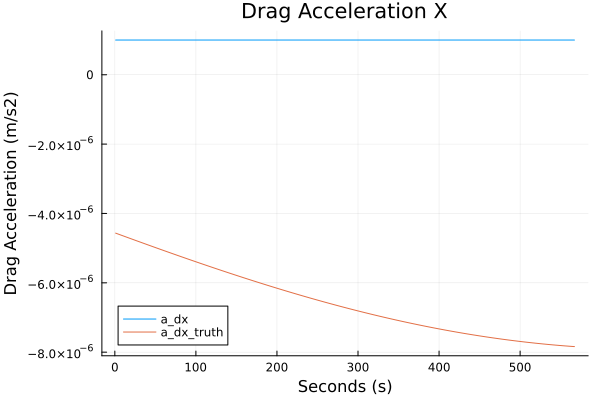

In [34]:
using Plots

t = 1:CV_num

x = plot(t, all_states[7,:], title="Drag Acceleration X", label= "a_dx", xlabel = "Seconds (s)", ylabel= "Drag Acceleration X (m/s2)")

plot!(t, all_drag[1,:], title="Drag Acceleration X", label= "a_dx_truth", xlabel = "Seconds (s)", ylabel= "Drag Acceleration (m/s2)")

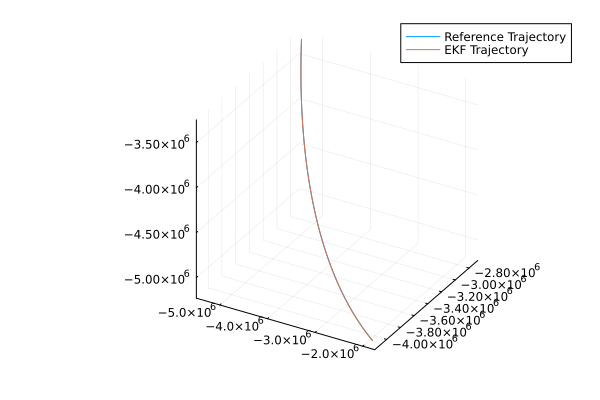

In [35]:
#Plot the reference trajectory and the EKF Trajectory
plot(x_hist[1,:], x_hist[2,:], x_hist[3,:], label = "Reference Trajectory")
plot!(all_states[1,:], all_states[2,:], all_states[3,:], label = "EKF Trajectory")

In [36]:
x_hist[:,:]-all_states[1:6,:]

6×567 Matrix{Float64}:
  71.2391      71.3326      71.4266     …  180.742     181.009     181.277
 133.387      133.438      133.49          195.878     196.085     196.292
 121.484      121.537      121.591         200.682     200.956     201.232
   0.0933908    0.0937836    0.0941765       0.267245    0.267337    0.267426
   0.0517155    0.0518018    0.0518886       0.20633     0.206794    0.207259
   0.0531011    0.0532528    0.0534053  …    0.274299    0.274934    0.27557

In [37]:
R_end = cov_sqrt_all[end]

sigma_end = R_end'*R_end

#final position standard deviation
sat_final_std = sqrt(tr(sigma_end[1:3, 1:3])) 

print("This is the final position accuracy of the CV EKF")
display(sat_final_std)

sat_std_x = sqrt(sigma_end[1,1]);
sat_std_y = sqrt(sigma_end[2,2]);
sat_std_z = sqrt(sigma_end[3,3]);

This is the final position accuracy of the CV EKF

683.496363999013

In [38]:
satvel_std_x = sqrt(sigma_end[4,4]);
satvel_std_y = sqrt(sigma_end[5,5]);
satvel_std_z = sqrt(sigma_end[6,6]);

In [39]:
#final position standard deviation
drag_final_std = sqrt(tr(sigma_end[7:9, 7:9]))

drag_std_x = sqrt(sigma_end[7,7]);
drag_std_y = sqrt(sigma_end[8,8]);
drag_std_z = sqrt(sigma_end[9,9]);

In [40]:
vel_bias = x_hist[4:6, :] - all_states[4:6,:] 

3×567 Matrix{Float64}:
 0.0933908  0.0937836  0.0941765  0.0945695  …  0.267245  0.267337  0.267426
 0.0517155  0.0518018  0.0518886  0.0519761     0.20633   0.206794  0.207259
 0.0531011  0.0532528  0.0534053  0.0535585     0.274299  0.274934  0.27557

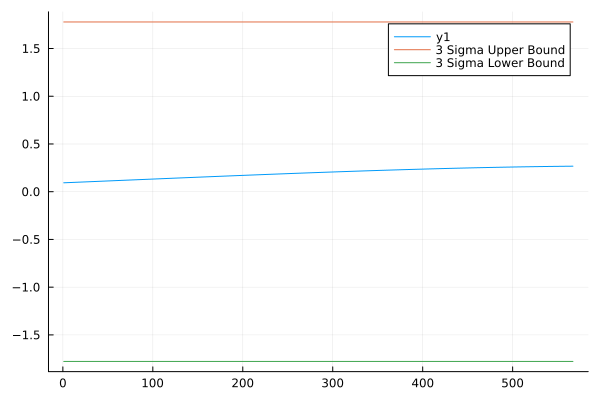

In [41]:
plot(t, vel_bias[1,:])
plot!(t, 3*satvel_std_x*ones(size(t)), label= "3 Sigma Upper Bound")
plot!(t, -3*satvel_std_x*ones(size(t)), label = "3 Sigma Lower Bound")

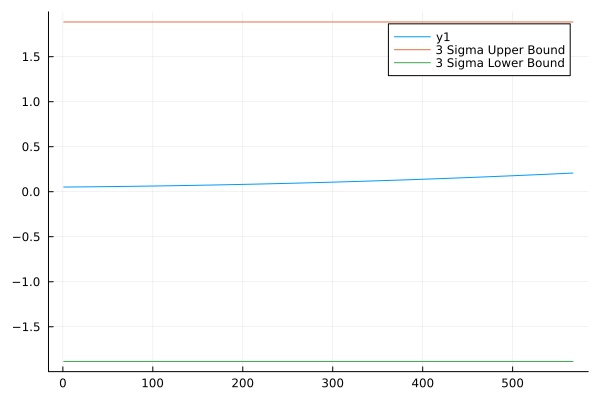

In [42]:
plot(t, vel_bias[2,:])
plot!(t, 3*satvel_std_y*ones(size(t)), label= "3 Sigma Upper Bound")
plot!(t, -3*satvel_std_y*ones(size(t)), label = "3 Sigma Lower Bound")

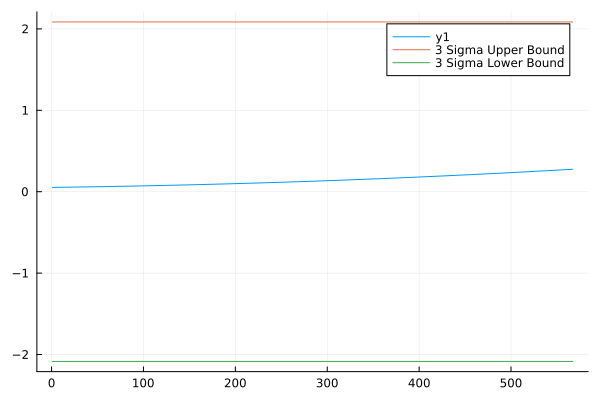

In [43]:
plot(t, vel_bias[3,:])
plot!(t, 3*satvel_std_z*ones(size(t)), label= "3 Sigma Upper Bound")
plot!(t, -3*satvel_std_z*ones(size(t)), label = "3 Sigma Lower Bound")

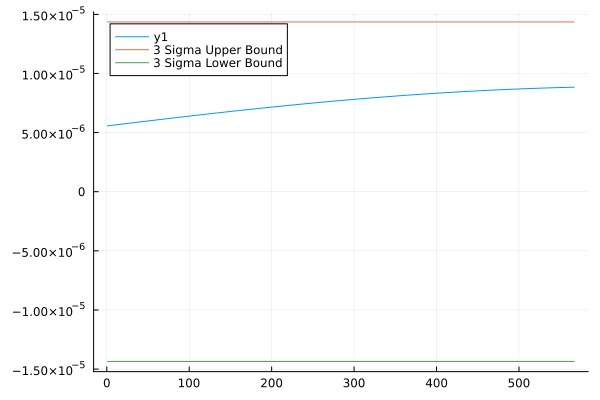

In [44]:
#Plotting Bias for the accelerations
bias1 = all_states[7,:] - all_drag[1,:]

plot(t, bias1)
plot!(t, 3*drag_std_x*ones(size(t)), label= "3 Sigma Upper Bound")
plot!(t, -3*drag_std_x*ones(size(t)), label = "3 Sigma Lower Bound")

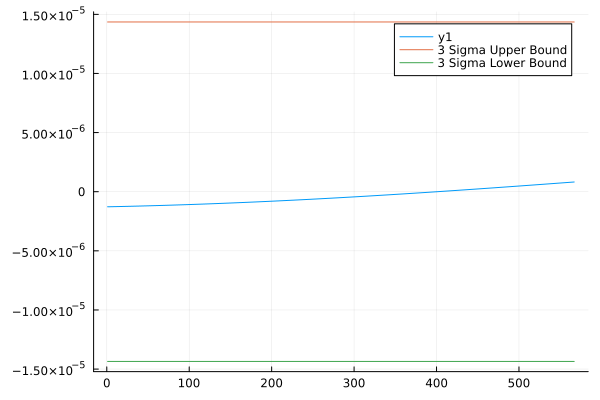

In [45]:
#Plotting Bias for the accelerations
bias2 = all_states[8,:] - all_drag[2,:]

plot(t, bias2)
plot!(t, 3*drag_std_y*ones(size(t)), label= "3 Sigma Upper Bound")
plot!(t, -3*drag_std_y*ones(size(t)), label = "3 Sigma Lower Bound")

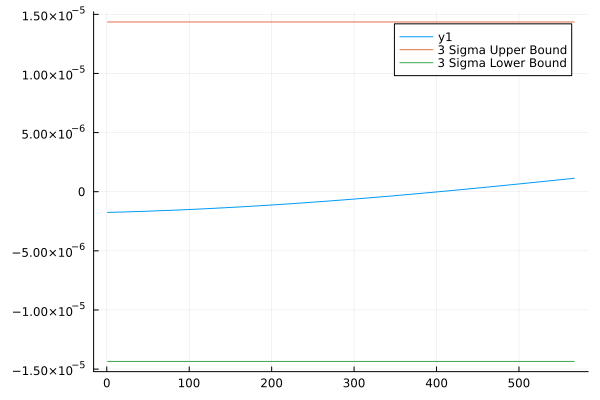

In [46]:
#Plotting Bias for the accelerations
bias3= all_states[9,:] - all_drag[3,:]

plot(t, bias3)
plot!(t, 3*drag_std_z*ones(size(t)), label= "3 Sigma Upper Bound")
plot!(t, -3*drag_std_z*ones(size(t)), label = "3 Sigma Lower Bound")

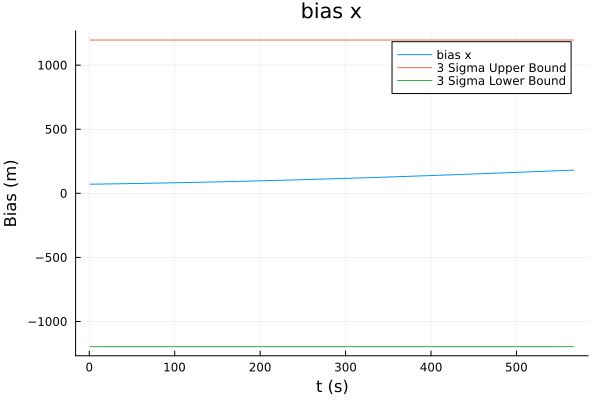

In [47]:
difference = x_hist[1:3,:] - all_states[1:3,:]

size(difference)
#normz = norm.(eachrow(difference))

#display(x_hist_scaled[1:3,90])
#display(all_states[1:3,90])

plot(t, difference[1,:], label = "bias x", xlabel = "t (s)", ylabel = "Bias (m)", title = "bias x")

plot!(t, 3*sat_std_x*ones(size(t)), label= "3 Sigma Upper Bound")
plot!(t, -3*sat_std_x*ones(size(t)), label = "3 Sigma Lower Bound")

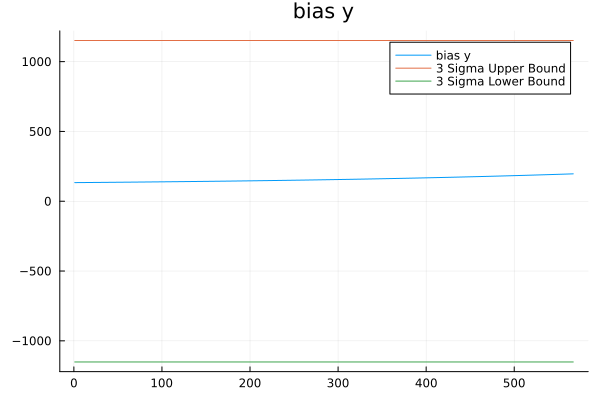

In [48]:
plot(t, difference[2,:], label = "bias y", title= "bias y")
plot!(t, 3*sat_std_y*ones(size(t)), label= "3 Sigma Upper Bound")
plot!(t, -3*sat_std_y*ones(size(t)), label= "3 Sigma Lower Bound")

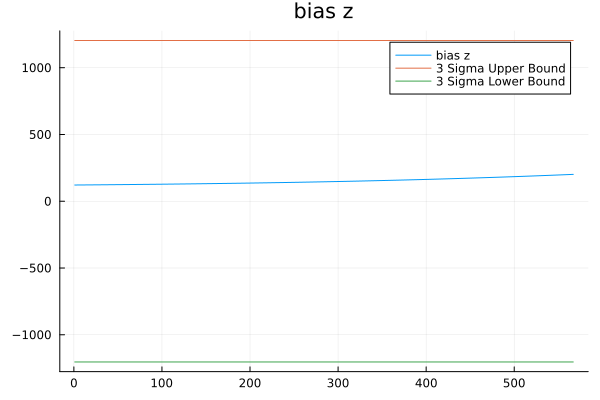

In [49]:
plot(t, difference[3,:], label = "bias z", title= "bias z")
plot!(t, 3*sat_std_z*ones(size(t)), label= "3 Sigma Upper Bound")
plot!(t, -3*sat_std_z*ones(size(t)), label= "3 Sigma Lower Bound")